# Imports

In [92]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from typing import Optional, Literal
from jaxtyping import Float, jaxtyped
from typeguard import typechecked as typechecker
import einops
from tqdm.notebook import tqdm
from dataclasses import dataclass

# Model definition

In [76]:
@dataclass
class ModelsConfig:
    # Sweep over several models to reduce noise, following the paper
    n_models: int = 10
    # The paper sweeps over 50 densities and importances
    n_densities: int = 50
    n_importances: int = 50
    # The setup is a 2D -> 1D -> 2D mapping
    d_feature: int = 2
    d_model: int = 1
    device: str = "cuda"

In [77]:
@jaxtyped(typechecker=typechecker)
class ReLUModels(nn.Module):
    def __init__(self, cfg: ModelsConfig):
        super().__init__()

        self.cfg = cfg
        n_models = cfg.n_models
        n_densities = cfg.n_densities
        n_importances = cfg.n_importances
        d_feature = cfg.d_feature
        d_model = cfg.d_model
        device = cfg.device

        # W: (n_models, n_densities, n_importances, d_feature, d_model, d_feature, d_model)
        # b: (n_models, n_densities, n_importances, d_feature)

        self.W = nn.Parameter(torch.empty(n_models, n_densities, n_importances, d_feature, d_model, device=device))
        # Kaiming initialization works better than Xavier for layers with ReLU activation
        # See https://stats.stackexchange.com/questions/319323/whats-the-difference-between-variance-scaling-initializer-and-xavier-initialize/319849#319849
        nn.init.kaiming_normal_(self.W)

        self.b = nn.Parameter(torch.zeros(n_models, n_densities, n_importances, d_feature, device=device))

    def forward(
            self, x: Float[Tensor, "n_models n_densities n_importances batch_size d_feature"]
    ) -> Float[Tensor, "n_models n_densities n_importances batch_size d_feature"]:
        h = einops.einsum(
            x, self.W,
            "model density importance batch d_feature, model density importance d_feature d_model -> model density importance batch d_model"
        )
        out = F.relu(
            einops.einsum(
                h, self.W,
                "model density importance batch d_model, model density importance d_feature d_model -> model density importance batch d_feature"
            ) + self.b.unsqueeze(-2) # unsqueeze adds batch dimension to b
        )
        return out

# Data generation

In [78]:
@jaxtyped(typechecker=typechecker)
def generate_batch(
        cfg: ModelsConfig, batch_size: int, densities: Float[Tensor, "n_densities"], device: str ='cuda'
) -> Float[Tensor, "n_models n_densities n_importances batch_size d_feature"]:
    n_models = cfg.n_models
    n_densities = cfg.n_densities
    n_importances = cfg.n_importances
    d_feature = cfg.d_feature

    feat_vals = torch.rand(n_models, n_densities, n_importances, batch_size, d_feature, device=device)
    feat_probs = torch.rand(n_models, n_densities, n_importances, batch_size, d_feature, device=device)
    # Add importance, batch and feature dims to densities for broadcasting     
    sparsity_mask = feat_probs < densities.view(-1, 1, 1, 1)
    # Only those feats with prob < respective density will be present in the generated data
    return feat_vals * sparsity_mask

# Loss function

In [79]:
@jaxtyped(typechecker=typechecker)
class ImportanceWeightedMSELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(
            self,
            input: Float[Tensor, "n_models n_densities n_importances batch_size d_feature"],
            target: Float[Tensor, "n_models n_densities n_importances batch_size d_feature"],
            importances: Float[Tensor, "importances"]
    ) -> Float[Tensor, "n_models n_densities n_importances"]:
        squared_error = (target - input) ** 2
        # unsqueeze(-2) adds batch dimension to importances before multiplying.
        # After adding the new dimension, importances is of shape
        # (n_importances, 1, d_feature) and squared_error is of the same shape
        # as input, i.e., (..., n_importances, batch_size, d_feature).
        # Then, we return the mean error over features and batches.
        return einops.reduce(
            squared_error * importances.unsqueeze(-2),
            "... batch feature -> ...",
            "mean"
        )

# Training loop

In [93]:
@dataclass
class TrainingArgs:
    lr: float = 1e-3
    n_epochs: int = 6000
    log_interval: int = 150
    batch_size: int = 1024

In [94]:
def train(models: ReLUModels, training_args: TrainingArgs, optimizer: optim.Optimizer, loss_fn: nn.Module, densities, importances, device='cuda'):
    optimizer = optimizer(models.parameters(), lr=training_args.lr)
    loss_fn = loss_fn()

    # Create 1-vs-importance tensor, where 1 represents the importance of the
    # first feature relative to the second one
    importances = torch.stack((torch.ones(models.cfg.n_importances, device=device), importances), dim=1)

    epochs = []
    losses = []

    # Plot loss over epochs in real time
    plt.ion()
    fig, ax = plt.subplots()
    line, = ax.plot(epochs, losses)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss over Epochs')

    for epoch in tqdm(range(1, training_args.n_epochs + 1)):
        batch = generate_batch(models.cfg, training_args.batch_size, densities, device)
        # Mean loss over the variables of interest (density and importance) as
        # well as different models
        loss = (loss_fn(batch, models(batch), importances)).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epochs.append(epoch)
        losses.append(loss.item())

        line.set_xdata(epochs)
        line.set_ydata(losses)
        ax.relim()
        ax.autoscale_view()
        fig.canvas.draw()
        fig.canvas.flush_events()

        if epoch % training_args.log_interval == 0:
            print(f"Epoch [{epoch}/{training_args.n_epochs}]: loss = {loss.item():.6f}")

    # Turn off interactive mode and show the final plot
    plt.ioff()
    plt.show()

# Plotting functions

## Weighting

The weighting parameter determines how models are weighted. By default, they are weighted equally.
- `inverse_loss`: Weighted according to the inverse of the their losses. That is, for every importance-density pair, we weight the models we have trained by how well they perform. Higher-performing models contribute more strongly to the results plot, since they more closely track the behavior of "ideally" trained ReLU autoencoders.
- `loss`: Weighted proportional to their losses. That is, the worst-performing models are weighted more highly. Just for fun.
- `drop_worst`: Drop the model with the highest loss. This is the weighting used in the paper, but I haven't implemented it yet.

In [95]:
# Norm magnitude corresponds to saturation (darkness) of pixel
# Strength of superposition goes from blue to red
def generate_pixel(superposition, norm):
    # Following the paper, values are in range [0, 1].
    # max(0, a) sets a floor of 0, min(a, 1) sets a ceiling of 1.
    # Chaining max and min in this fashion clamps the value between 0 and 1.
    superposition, norm = max(0, min(superposition, 1)), max(0, min(norm, 1))
    # On the HSV, 2/3 is blue and 1 is red
    blue, red = 2/3, 1
    hue = blue + (red - blue) * superposition
    return mpl.colors.hsv_to_rgb((hue, norm, 1))

@jaxtyped(typechecker=typechecker)
def visualize(models: ReLUModels, densities, importances, weighting: Optional[Literal["inverse_loss", "loss"]] = None, batch_size: int = 2048):
    n_densities = models.cfg.n_densities
    n_importances = models.cfg.n_importances

    models, importances, densities = models.cpu(), importances.cpu(), densities.cpu()
    W = models.W.detach()

    batch = generate_batch(models.cfg, batch_size, densities, 'cpu')
    importances = torch.stack((torch.ones(n_importances), importances), dim=1)

    feature_norms = W.norm(dim=-1)
    # Zero out self-interactions
    self_interactions_mask = (1 - torch.eye(models.cfg.d_feature))[None, None, :, :]
    feature_superpositions = torch.sum(((W @ W.transpose(-1, -2)) * self_interactions_mask) ** 2, dim=-2)

    models.eval()
    with torch.no_grad():
        preds = models(batch)

    # Generate weighting
    if weighting == "inverse_loss":
        imse_loss = ImportanceWeightedMSELoss()
        losses = imse_loss(preds, batch, importances)
        # The 0th dim is models
        weighting = F.normalize(1 / (losses.cpu() ** 2), p=1, dim=0).unsqueeze(-1)
    elif weighting == "loss":
        imse_loss = ImportanceWeightedMSELoss()
        losses = imse_loss(preds, batch, importances)
        weighting = F.normalize(losses.cpu() ** 2, p=1, dim=0).unsqueeze(-1)
    else:
        weighting = 1.0 # gets broadcast

    # Take weighted sum across models
    feature_norms_weighted_sum = einops.reduce(
        feature_norms * weighting,
        "n_models n_densities n_importances d_feature -> n_densities n_importances d_feature",
        "sum"
    )
    feature_superpositions_weighted_sum = einops.reduce(
        feature_superpositions * weighting,
        "n_models n_densities n_importances d_feature -> n_densities n_importances d_feature",
        "sum"
    )

    img = np.empty((n_densities, n_importances, 3))
    for d in range(n_densities):
        for i in range(n_importances):
            img[d, i, :] = generate_pixel(feature_superpositions_weighted_sum[d, i, 0], feature_norms_weighted_sum[d, i, 0])

    _, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(img, origin='lower', aspect='auto', extent=[np.log10(importances.min()), np.log10(importances.max()), np.log10(densities.min()), np.log10(densities.max())])
    # Set labels and title
    ax.set_xlabel('Relative importance (powers of 10)')
    ax.set_ylabel('Density (powers of 10)')
    ax.set_title('Feature Norms and Superpositions')

    # Set log scales for both axes
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    plt.tight_layout()
    plt.show()

# Device

In [96]:
# CPU on Colab will take >6 hours to train, but <10 seconds for inference (plotting)
device = 'cuda'

# Intializing models, densities and importances

In [97]:
models_cfg = ModelsConfig()
models = ReLUModels(models_cfg)

# Both features' density is log-spaced from 0.01 to 1
densities = 10 ** torch.linspace(-2, 0, 50, device=device)
# Relative importance of the second feature is log-spaced from 0.1 to 10
importances = 10 ** torch.linspace(-1, 1, 50, device=device)

# Seed for reproducibility

In [98]:
torch.manual_seed(42)
np.random.seed(42)

# Training and saving model

  0%|          | 0/6000 [00:00<?, ?it/s]

Epoch [150/6000]: loss = 0.077857
Epoch [300/6000]: loss = 0.051662
Epoch [450/6000]: loss = 0.036758
Epoch [600/6000]: loss = 0.026036
Epoch [750/6000]: loss = 0.019554
Epoch [900/6000]: loss = 0.016509
Epoch [1050/6000]: loss = 0.015120
Epoch [1200/6000]: loss = 0.014436
Epoch [1350/6000]: loss = 0.014042
Epoch [1500/6000]: loss = 0.013831
Epoch [1650/6000]: loss = 0.013733
Epoch [1800/6000]: loss = 0.013647
Epoch [1950/6000]: loss = 0.013589
Epoch [2100/6000]: loss = 0.013522
Epoch [2250/6000]: loss = 0.013457
Epoch [2400/6000]: loss = 0.013402
Epoch [2550/6000]: loss = 0.013326
Epoch [2700/6000]: loss = 0.013271
Epoch [2850/6000]: loss = 0.013205
Epoch [3000/6000]: loss = 0.013130
Epoch [3150/6000]: loss = 0.013072
Epoch [3300/6000]: loss = 0.013049
Epoch [3450/6000]: loss = 0.013002
Epoch [3600/6000]: loss = 0.012972
Epoch [3750/6000]: loss = 0.012927
Epoch [3900/6000]: loss = 0.012907
Epoch [4050/6000]: loss = 0.012883
Epoch [4200/6000]: loss = 0.012856
Epoch [4350/6000]: loss = 

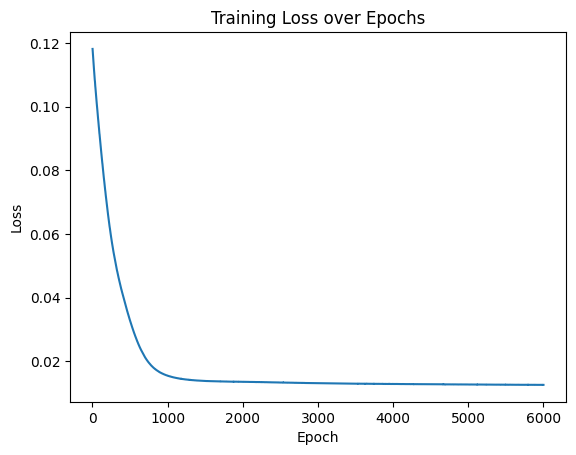

Training complete.


In [99]:
train(models, TrainingArgs(), optim.AdamW, ImportanceWeightedMSELoss, densities, importances, device)
print("Training complete.")

In [100]:
from google.colab import drive
drive.mount('/content/drive')
# save_path = '/content/drive/My Drive/toy-models-superpos/relus-across-densities-and-importances.pth'
save_path = '/content/drive/My Drive/toy-models-superpos/relus-across-densities-and-importances-new.pth'
torch.save(models.state_dict(), save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Plotting results

In [101]:
from google.colab import drive
drive.mount('/content/drive')
# models.load_state_dict(torch.load('/content/drive/My Drive/toy-models-superpos/relus-across-densities-and-importances.pth', map_location=torch.device('cpu')))
models.load_state_dict(torch.load('/content/drive/My Drive/toy-models-superpos/relus-across-densities-and-importances-new.pth', map_location=torch.device('cpu')))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-101-6754d332af13>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models.load_state_dict(torch.load('/content/drive/My Drive/toy-models-superpos/relus-across

<All keys matched successfully>

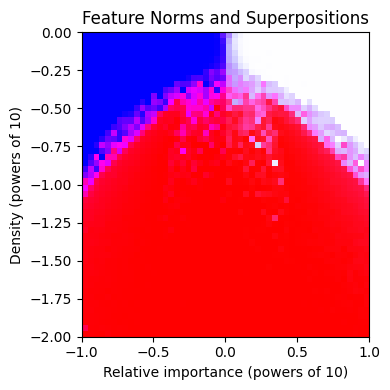

In [102]:
visualize(models, densities, importances, weighting="inverse_loss")

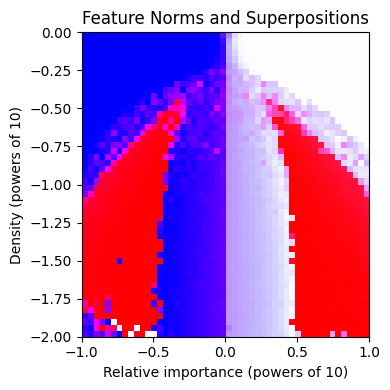

In [103]:
visualize(models, densities, importances, weighting="loss")

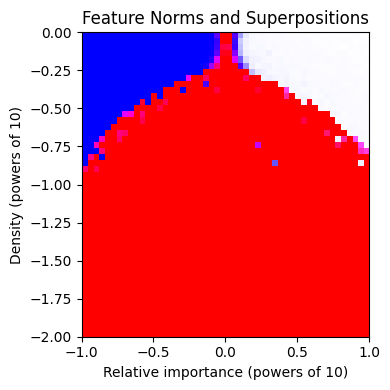

In [104]:
visualize(models, densities, importances)